### Seasonality of the marine terminus and basic influencing factors

In [16]:
# Import required libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Set base path for data files
basepath = r"..."

# Define color palette
COLORS = {
    'lake': '#ca3e3dff',
    'marine': '#46556aff',
    'light_marine': '#707c92ff',
    'background': '#f8f6f4ff',
    'shading': '#e7e5e3ff',
    'dark_red': '#9c2626ff',
    'olive': '#677834ff',
    'light_olive': '#9da737ff',
    'dark_olive': '#364621ff',
    'purple': '#792c74ff',
    'teal': '#10677aff'
}

def read_MT_margins(path):
    """
    Read and process marine terminus margin data.
    
    Parameters:
    -----------
    path : str
        Path to the MT margins CSV file
    
    Returns:
    --------
    pandas.DataFrame
        Processed marine terminus data with datetime index
    """
    MT = pd.read_csv(
        path,
        skiprows=2,
        names=["year", "month", "day", "serial_date", "pos_flowline", "pos_rel", 
               "change", "change_rate", "terminus_width", "path_length", 
               "node_distance", "box_width", "box_area"]
    )
    
    # Create datetime index
    MT['date'] = MT['year'].astype(str) + '-' + MT['month'].astype(str) + '-' + MT['day'].astype(str)
    MT.index = pd.to_datetime(MT['date'])
    MT.sort_index(inplace=True)
    
    # Calculate relative position in kilometers
    MT['pos_rel_inv'] = ((MT['pos_rel'] - MT['pos_rel'].iloc[3]) * (-1)) / 1000
    
    return MT

#### reading the datasets

In [ ]:
# Read marine terminus margins data
MT = read_MT_margins(basepath + r"...\3.1_glacier_margins_and_flowline\MT_margins.csv")

# Calculate annual min/max positions and range
min_indices = MT.groupby('year')['pos_flowline'].idxmin()
max_indices = MT.groupby('year')['pos_flowline'].idxmax()
min_max_diff = MT.groupby('year')['pos_flowline'].max() - MT.groupby('year')['pos_flowline'].min()

In [ ]:
# Read and process air temperature data
temp = pd.read_csv(basepath + r"...\3.8_racmo_oras5_dmi\427000.csv", sep=";", parse_dates=True)

# Rename columns for clarity
temp = temp.rename(columns={
    'Hour(utc)': 'Hour',
    '101': 'temp',
    '112': 'max_temp_1h',
    '113': 'max_temp_12h',
    '122': 'min_temp_1h',
    '123': 'min_temp_12h',
    '603': 'precip_12h',
    '601': 'precip_1h',
    '801': 'cloud_cover'
})

# Create datetime index
temp['datetime'] = pd.to_datetime(temp[['Year', 'Month', 'Day', 'Hour']])
temp.set_index('datetime', inplace=True)

# Resample temperature to different time scales
temp_daily = temp[['temp']].resample('D').mean()
temp_monthly = temp['temp'].resample('ME').mean()
temp_yearly = temp['temp'].resample('YE').mean()

# Resample precipitation to different time scales
precip_daily = temp['precip_12h'].resample('D').sum()
precip_monthly = temp['precip_12h'].resample('ME').sum()
precip_yearly = temp['precip_12h'].resample('YE').sum()

In [ ]:
# Read and process RACMO runoff data
runoff = pd.read_csv(
    basepath + r"...\3.8_racmo_oras5_dmi\runoff_whole_catchment.csv",
    usecols=["time", 'runoffcorr'],
    index_col='time',
    parse_dates=True
)

runoff.index = pd.to_datetime(runoff.index)

# Calculate yearly runoff (in thousands) with 6-month offset
runoffyearly = runoff.resample('YE').sum() / 1000
runoffyearly.index = runoffyearly.index - pd.offsets.DateOffset(months=6)

In [ ]:
# Read ORAS5 ocean temperature data
ORAS_temp = pd.read_csv(basepath + r"...\3.8_racmo_oras5_dmi\ORAS5_20100.csv", sep=",")
ORAS_temp.index = pd.to_datetime(ORAS_temp.time)

#### Prepare for plotting

In [22]:
# Define time range for analysis
START_DATE = '2014-01-01'
END_DATE = '2024-12-31'

# Filter datasets to the specified time range
temp_filtered = temp_daily.loc[START_DATE:END_DATE].copy()
runoff_filtered = runoff.loc[START_DATE:END_DATE].copy()
MT_filtered = MT.loc[START_DATE:END_DATE].copy()
ORAS_temp_filtered = ORAS_temp.loc[START_DATE:END_DATE].copy()

# Add day of year column
temp_filtered['doy'] = temp_filtered.index.dayofyear
runoff_filtered['doy'] = runoff_filtered.index.dayofyear

# Remove leap year days (February 29)
temp_filtered = temp_filtered[~((temp_filtered.index.month == 2) & (temp_filtered.index.day == 29))]
runoff_filtered = runoff_filtered[~((runoff_filtered.index.month == 2) & (runoff_filtered.index.day == 29))]

In [23]:
# Interpolate marine terminus data to daily resolution
# This distributes the change between observation dates evenly across days

MT_filtered = MT_filtered.sort_index()
daily_records = []

# Loop through consecutive date pairs
for i in range(len(MT_filtered) - 1):
    start_date = MT_filtered.index[i]
    end_date = MT_filtered.index[i + 1]
    change = MT_filtered['change'].iloc[i]
    
    # Calculate number of days and daily change rate
    num_days = (end_date - start_date).days
    daily_change = change / num_days
    
    # Create daily records for the period
    for day in pd.date_range(start=start_date + pd.Timedelta(days=1), end=end_date):
        daily_records.append((day, daily_change))

# Convert to DataFrame
daily_MT = pd.DataFrame(daily_records, columns=['date', 'daily_change']).set_index('date')

# Aggregate to monthly resolution
MT_monthly = daily_MT.resample('ME').sum()

print(daily_MT.head())

            daily_change
date                    
2014-01-24     -0.177947
2014-01-25     -0.177947
2014-01-26     -0.177947
2014-01-27     -0.177947
2014-01-28     -0.177947


C:\Users\florian\AppData\Local\Temp\ipykernel_4200\3103696376.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  daily_change = change / num_days


In [24]:
# Calculate climatological averages (average by day/month across all years)

# Daily climatology
temp_daily_avg = temp_filtered.groupby('doy')['temp'].mean()
runoff_daily_avg = runoff_filtered.groupby('doy')['runoffcorr'].mean()

# Monthly climatology
temp_monthly_avg = temp_filtered.groupby(temp_filtered.index.month)['temp'].mean()
runoff_monthly_avg = runoff_filtered.groupby(runoff_filtered.index.month)['runoffcorr'].mean()
ORAS_temp_monthly_avg = ORAS_temp_filtered.groupby(ORAS_temp_filtered.index.month)['depth_avg'].mean()

# Marine terminus monthly average (converted to m/day)
MT_monthly_avg = MT_monthly.groupby(MT_monthly.index.month)['daily_change'].mean()
MT_monthly_avg = MT_monthly_avg * -1 / 30

#### plotting with seaborn

In [25]:
# Prepare monthly data for plotting with proper month labels
MT_monthly['month'] = MT_monthly.index.month
MT_monthly['month_label'] = MT_monthly.index.strftime('%b')
MT_monthly['month'] = pd.Categorical(
    MT_monthly['month_label'],
    categories=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
    ordered=True
)

# Convert to retreat rate in m/day
MT_monthly['daily_change'] = MT_monthly['daily_change'] * -1 / 30

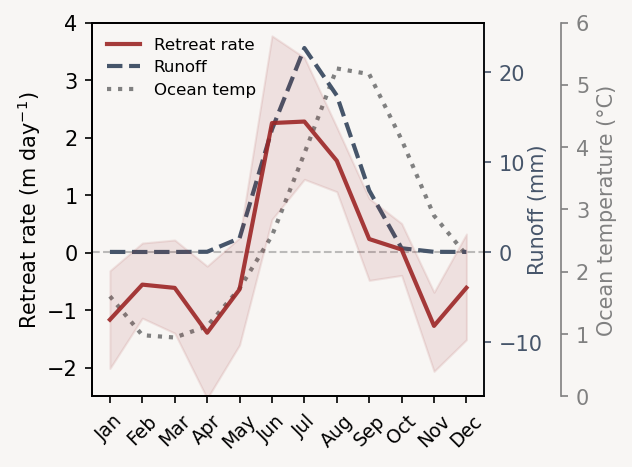

In [ ]:
# Create multi-axis plot showing seasonal patterns
fig, ax = plt.subplots(figsize=(4.1, 3), dpi=150, facecolor=COLORS['background'], layout="constrained")
ax.set_facecolor(COLORS['background'])

# Plot marine terminus retreat rate with confidence interval
sns.lineplot(
    data=MT_monthly,
    x='month',
    y='daily_change',
    estimator='mean',
    errorbar='ci',
    n_boot=1000,
    color=COLORS['dark_red'],
    ax=ax,
    linewidth=2,
    label='Retreat rate',
    alpha=0.9
)
plt.setp(ax.collections[0], alpha=0.1)

# Add runoff on second y-axis
ax2 = ax.twinx()
ax2.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax2.plot(
    runoff_monthly_avg.index - 1,
    runoff_monthly_avg.values,
    label='Runoff',
    color=COLORS['marine'],
    linestyle='--',
    linewidth=2
)

# Add ocean temperature on third y-axis
ax3 = ax.twinx()
ax3.plot(
    ORAS_temp_monthly_avg.index - 1,
    ORAS_temp_monthly_avg.values,
    color='gray',
    linestyle='dotted',
    linewidth=2,
    label='Ocean temp'
)

# Customize axis appearance
ax.tick_params(axis='x', labelrotation=45, labelsize=9)
ax.tick_params(axis='y', labelsize=10)
ax2.tick_params(axis='y', colors=COLORS['marine'], which="both", labelsize=10)
ax3.tick_params(axis='y', colors='gray', which="both", labelsize=10)

ax2.spines['right'].set_color(COLORS['marine'])
ax3.spines['right'].set_position(('outward', 37))
ax3.spines['right'].set_color('gray')

# Set axis limits
ax.set_ylim(-2.5, 4)
ax2.set_ylim(-16, 25.5)
ax3.set_ylim(0, 6)

# Add labels
ax.set_xlabel(None)
ax.set_ylabel(r'Retreat rate (m day$^{-1}$)', fontsize=10, labelpad=2)
ax3.set_ylabel('Ocean temperature (°C)', color='gray', fontsize=10)
ax2.set_ylabel('Runoff (mm)', color=COLORS['marine'], fontsize=10, labelpad=-7)

# Add legends
ax.legend(frameon=False, loc='upper left', fontsize=8)
ax2.legend(frameon=False, loc='upper left', fontsize=8, bbox_to_anchor=(0, 0.94))
ax3.legend(frameon=False, loc='upper left', fontsize=8, bbox_to_anchor=(0, 0.88))

# Set axis layering order
ax.set_zorder(3)
ax.patch.set_visible(False)
ax2.set_zorder(2)
ax3.set_zorder(1)

plt.gca().set_facecolor(COLORS['background'])
plt.show()

# Save figure
#fig.savefig(r'...path', dpi=300)